# This is a tutorial of using spaVAE for the human DLPFC section 151673 data

This tutorial was implemented on Macbook Pro M1.

Import modules.

In [ ]:
import math, os
from time import time

import torch
from spaVAE import SPAVAE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import h5py
import scanpy as sc
from preprocess import normalize, geneSelection

Setup parameters.

In [2]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'sample_151673.h5'
        self.select_genes = 0
        self.batch_size = "auto"
        self.maxiter = 5000
        self.train_size = 0.95
        self.patience = 200
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.noise = 0
        self.dropoutE = 0
        self.dropoutD = 0
        self.encoder_layers = [128, 64]
        self.GP_dim = 2
        self.Normal_dim = 8
        self.decoder_layers = [128]
        self.init_beta = 10
        self.min_beta = 4
        self.max_beta = 25
        self.KL_loss = 0.025
        self.num_samples = 1
        self.fix_inducing_points = True
        self.grid_inducing_points = True
        self.inducing_point_steps = 6
        self.inducing_point_nums = None
        self.fixed_gp_params = False
        self.loc_range = 20.
        self.kernel_scale = 20.
        self.model_file = "model.pt"
        self.final_latent_file = "final_latent.txt"
        self.denoised_counts_file = "denoised_counts.txt"
        self.num_denoise_samples = 10000
        self.device = "cpu"

args = Args()

Setup inducing points, preprocess count matrix, and build the spaVAE model.

In [3]:
print(args)

data_mat = h5py.File(args.data_file, 'r')
x = np.array(data_mat['X']).astype('float64') # count matrix
loc = np.array(data_mat['pos']).astype('float64') # location information
data_mat.close()

if args.batch_size == "auto":
    if x.shape[0] <= 1024:
        args.batch_size = 128
    elif x.shape[0] <= 2048:
        args.batch_size = 256
    else:
        args.batch_size = 512
else:
    args.batch_size = int(args.batch_size)

print(args)

if args.select_genes > 0:
    importantGenes = geneSelection(x, n=args.select_genes, plot=False)
    x = x[:, importantGenes]
    np.savetxt("selected_genes.txt", importantGenes, delimiter=",", fmt="%i")

scaler = MinMaxScaler()
loc = scaler.fit_transform(loc) * args.loc_range

print(x.shape)
print(loc.shape)

# We provide two ways to generate inducing point, argument "grid_inducing_points" controls whether to choice grid inducing or k-means
# One way is grid inducing points, argument "inducing_point_steps" controls number of grid steps, the resulting number of inducing point is (inducing_point_steps+1)^2
# Another way is k-means on the locations, argument "inducing_point_nums" controls number of inducing points
if args.grid_inducing_points:
    eps = 1e-5
    initial_inducing_points = np.mgrid[0:(1+eps):(1./args.inducing_point_steps), 0:(1+eps):(1./args.inducing_point_steps)].reshape(2, -1).T * args.loc_range
    print(initial_inducing_points.shape)
else:
    loc_kmeans = KMeans(n_clusters=args.inducing_point_nums, n_init=100).fit(loc)
    np.savetxt("location_centroids.txt", loc_kmeans.cluster_centers_, delimiter=",")
    np.savetxt("location_kmeans_labels.txt", loc_kmeans.labels_, delimiter=",", fmt="%i")
    initial_inducing_points = loc_kmeans.cluster_centers_

adata = sc.AnnData(x, dtype="float64")

adata = normalize(adata,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

model = SPAVAE(input_dim=adata.n_vars, GP_dim=args.GP_dim, Normal_dim=args.Normal_dim, encoder_layers=args.encoder_layers, decoder_layers=args.decoder_layers,
    noise=args.noise, encoder_dropout=args.dropoutE, decoder_dropout=args.dropoutD,
    fixed_inducing_points=args.fix_inducing_points, initial_inducing_points=initial_inducing_points, 
    fixed_gp_params=args.fixed_gp_params, kernel_scale=args.kernel_scale, N_train=adata.n_obs, KL_loss=args.KL_loss, init_beta=args.init_beta, min_beta=args.min_beta, 
    max_beta=args.max_beta, dtype=torch.float64, device=args.device)

print(str(model))

(3639, 3000)
(3639, 2)
(49, 2)
SPAVAE(
  (svgp): SVGP(
    (kernel): CauchyKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=3000, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
    (enc_mu): Linear(in_features=64, out_features=10, bias=True)
    (enc_var): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
  )
  (dec_mean): Sequential(
    (0): Linear(in_features=128, out_features=3000, bias=True)
    (1): MeanAct()
  )
  (NB_loss): NBLoss()
)


Train the model.

In [4]:
if not os.path.isfile(args.model_file):
    t0 = time()
    model.train_model(pos=loc, ncounts=adata.X, raw_counts=adata.raw.X, size_factors=adata.obs.size_factors,
            lr=args.lr, weight_decay=args.weight_decay, batch_size=args.batch_size, num_samples=args.num_samples,
            train_size=args.train_size, maxiter=args.maxiter, patience=args.patience, save_model=True, model_weights=args.model_file)
    print('Training time: %d seconds.' % int(time() - t0))
else:
    model.load_model(args.model_file)

final_latent = model.batching_latent_samples(X=loc, Y=adata.X, batch_size=args.batch_size)
np.savetxt(args.final_latent_file, final_latent, delimiter=",")

denoised_counts = model.batching_denoise_counts(X=loc, Y=adata.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.denoised_counts_file, denoised_counts, delimiter=",")

Training
Training epoch 1, ELBO:4354.68517521, NB loss:4332.00820767, GP KLD loss:0.02975802, Gaussian KLD loss:2.21314829, noise regularization:0.000000
Current beta 10.28909339164771
Current kernel scale tensor([20.0025])
Training epoch 1, validating ELBO:4066.04420951
Training epoch 2, ELBO:4137.45936642, NB loss:4118.87467860, GP KLD loss:0.03306441, Gaussian KLD loss:1.75250904, noise regularization:0.000000
Current beta 10.5635986726423
Current kernel scale tensor([20.0083])
Training epoch 2, validating ELBO:3876.63379694
Training epoch 3, ELBO:3964.45094865, NB loss:3939.99725098, GP KLD loss:0.03737959, Gaussian KLD loss:2.25384231, noise regularization:0.000000
Current beta 10.819954987728625
Current kernel scale tensor([20.0146])
Training epoch 3, validating ELBO:3720.23386824
Training epoch 4, ELBO:3823.22982645, NB loss:3795.29532649, GP KLD loss:0.04320553, Gaussian KLD loss:2.50888293, noise regularization:0.000000
Current beta 11.136412151672175
Current kernel scale tens

K-means clustering on the learned latent embedding of spaVAE, and refine the clustering labels by the majority of neighbors.

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

### refine clustering labels by the majority of neighbors
def refine(sample_id, pred, dis, shape="square"):
    refined_pred=[]
    pred=pd.DataFrame({"pred": pred}, index=sample_id)
    dis_df=pd.DataFrame(dis, index=sample_id, columns=sample_id)
    if shape=="hexagon":
        num_nbs=6 
    elif shape=="square":
        num_nbs=4
    else:
        print("Shape not recongized, shape='hexagon' for Visium data, 'square' for ST data.")
    for i in range(len(sample_id)):
        index=sample_id[i]
        dis_tmp=dis_df.loc[index, :].sort_values()
        nbs=dis_tmp.iloc[0:(num_nbs+1)]
        nbs_pred=pred.loc[nbs.index, "pred"]
        self_pred=pred.loc[index, "pred"]
        v_c=nbs_pred.value_counts()
        if (v_c.loc[self_pred]<num_nbs/2) and (np.max(v_c)>num_nbs/2):
            refined_pred.append(v_c.idxmax())
        else:           
            refined_pred.append(self_pred)
        if (i+1) % 1000 == 0:
            print("Processed", i+1, "lines")
    return np.array(refined_pred)

data_mat = h5py.File(args.data_file, 'r')
pos = np.array(data_mat['pos']).astype('float64')
y = np.array(data_mat['Y']).astype('U26') # ground-truth labels
data_mat.close()

index = y!='NA'

pred = KMeans(n_clusters=7, n_init=100).fit_predict(final_latent)
np.savetxt("clustering_labels.txt", pred, delimiter=",", fmt="%i")

nmi = np.round(metrics.normalized_mutual_info_score(y[index], pred[index]), 8)
ari = np.round(metrics.adjusted_rand_score(y[index], pred[index]), 8)
print("NMI:", nmi, "; ARI:", ari)

dis = pairwise_distances(pos, metric="euclidean", n_jobs=-1).astype(np.double)
pred_refined = refine(np.arange(pred.shape[0]), pred, dis, shape="hexagon")
np.savetxt("refined_clustering_labels.txt", pred_refined, delimiter=",", fmt="%i")

nmi = np.round(metrics.normalized_mutual_info_score(y[index], pred_refined[index]), 8)
ari = np.round(metrics.adjusted_rand_score(y[index], pred_refined[index]), 8)
print("Refined NMI:", nmi, "; refined ARI:", ari)

NMI: 0.71496711 ; ARI: 0.55373688
Processed 1000 lines
Processed 2000 lines
Processed 3000 lines
Refined NMI: 0.71536501 ; refined ARI: 0.55358524


Differential expression analysis of each layer vs others.

In [6]:
data_mat = h5py.File(args.data_file, 'r')
gene = np.array(data_mat['gene']).astype('U26') # gene names
data_mat.close()

# raw counts
raw_adata = sc.AnnData(x, dtype="float64")

raw_adata = normalize(raw_adata,
                  size_factors=True,
                  normalize_input=False,
                  logtrans_input=False)

for layer in np.unique(y):
    if layer == 'NA':
        continue
    layer_idx = np.where(np.array(y==layer, dtype=bool))[0]
    not_layer_idx = np.where(np.logical_and(np.array(y!=layer, dtype=bool), np.array(y!='NA', dtype=bool)))[0]

    res_dat = model.differential_expression(group1_idx=layer_idx, group2_idx=not_layer_idx, num_denoise_samples=args.num_denoise_samples,
                        batch_size=args.batch_size, pos=loc, ncounts=adata.X, gene_name=gene, raw_counts=raw_adata.X)

    res_dat.to_csv(layer+"_vs_others_LFC.txt")

Estimated pseudocounts 0.05
LFC delta: 0.3
Estimated pseudocounts 0.05
LFC delta: 0.3
Estimated pseudocounts 0.05
LFC delta: 0.30734085031572067
Estimated pseudocounts 0.05
LFC delta: 0.3
Estimated pseudocounts 0.05
LFC delta: 0.3
Estimated pseudocounts 0.05
LFC delta: 0.3
Estimated pseudocounts 0.05
LFC delta: 0.8749713046344475


## Plotting results in R and ggplot2.

Plot refined k-means clustering labels. Colors represent clustering labels.

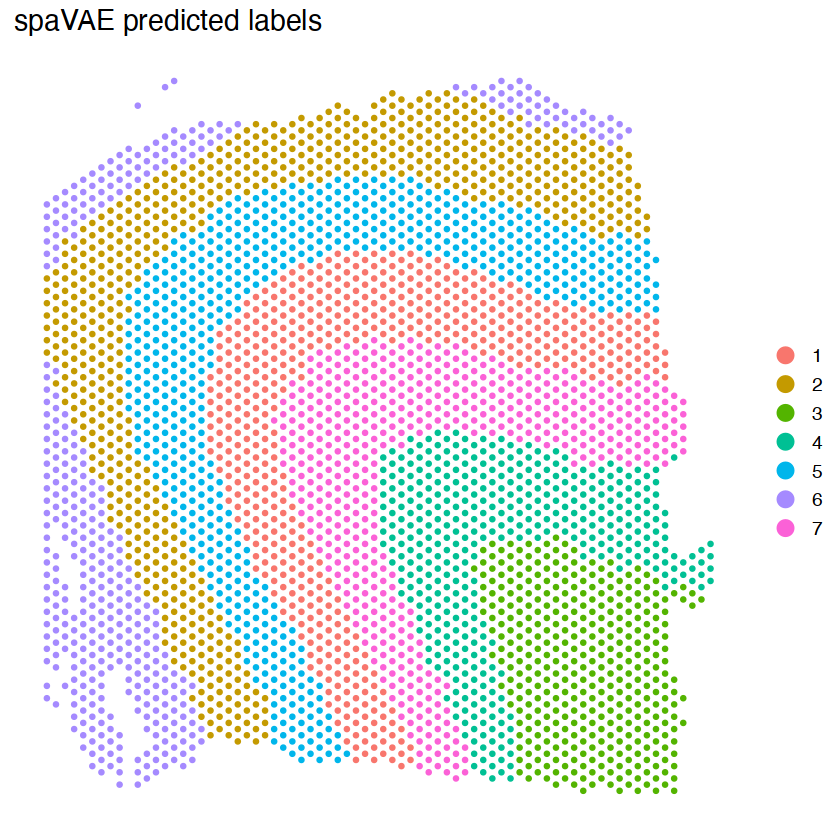

In [1]:
rm(list=ls())
library(ggplot2)
library(rhdf5)
library(umap)

pos <- t(h5read("sample_151673.h5", "pos"))
Y <- h5read("sample_151673.h5", "Y") # load ground-truth labels

refined_pred <- as.numeric(readLines("refined_clustering_labels.txt"))+1

pred_dat <- data.frame(refined_pred=refined_pred, pos_x=pos[,1], pos_y=pos[,2], Y=Y)
pred_dat$refined_pred <- factor(pred_dat$refined_pred, levels=1:7)

ggplot(subset(pred_dat, !is.na(Y)), aes(x=pos_x, y=pos_y, color=refined_pred)) + geom_point(size=0.8) + 
  theme_classic() + ggtitle("spaVAE predicted labels") +
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), legend.position="right", text = element_text(size=14)) +
  guides(colour = guide_legend(override.aes = list(size=4)))

Plot latent embedding of spaVAE. Colors represent ground-truth labels.

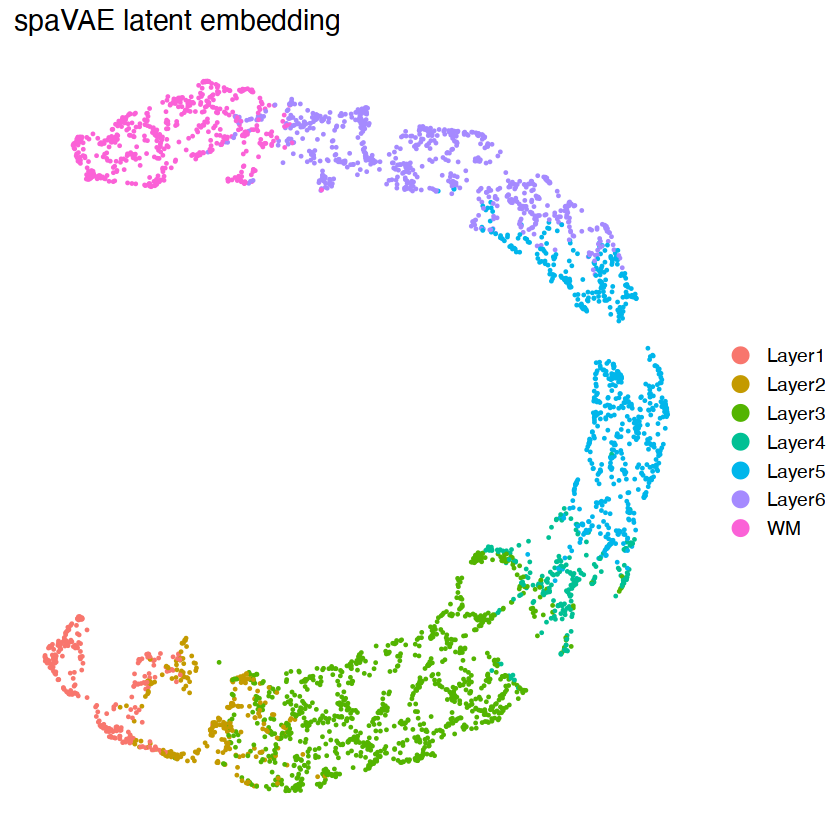

In [2]:
spaVAE_latent <- read.table("final_latent.txt", sep=",")

custom.config <- umap.defaults
custom.config$random_state <- 123

umap.res <- umap(spaVAE_latent, method="naive", config=custom.config)

spaVAE_umap <- data.frame(umap.res$layout, Y=Y)

ggplot(subset(spaVAE_umap, !is.na(Y)), aes(x=X1, y=X2, color=Y)) + geom_point(size=0.3) + 
  ggtitle("spaVAE latent embedding") + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), text = element_text(size=14)) +
  guides(colour = guide_legend(override.aes = list(size=4)))

Plot denoised counts of layer marker genes.

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Warning message:
“package ‘MatrixGenerics’ was built under R version 4.3.1”
Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumE

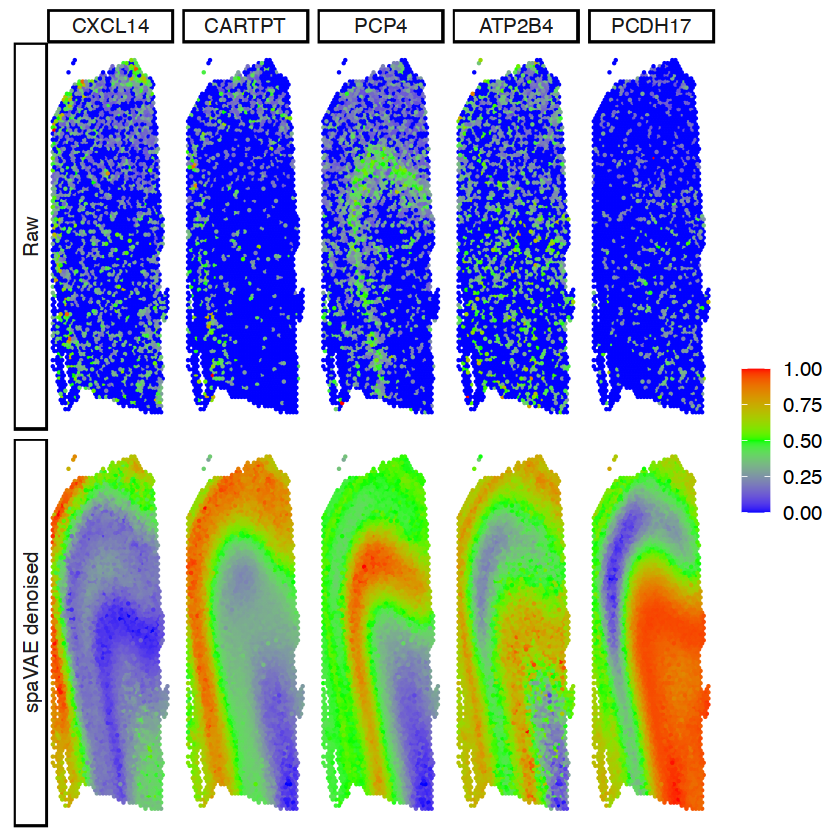

In [3]:
library(scater)

raw.counts <- h5read("sample_151673.h5", "X")
gene <- h5read("sample_151673.h5", "gene")
cell <- h5read("sample_151673.h5", "cell")
rownames(pos) <- cell

sce <- SingleCellExperiment(list(counts=as.matrix(raw.counts)))
rownames(sce) <- gene
colnames(sce) <- cell
sce <- logNormCounts(sce, size.factors = sizeFactors(sce))
lograwcounts <- sce@assays@data$logcounts
lograwcounts <- t(apply(lograwcounts, 1, function(z) scales::rescale(z, to=c(0,1))))

denoised.counts <- read.csv("denoised_counts.txt", header=F)
denoised.counts <- t(denoised.counts)
rownames(denoised.counts) <- gene
colnames(denoised.counts) <- cell
logdenoisedcounts <- log(denoised.counts)
logdenoisedcounts <- t(apply(logdenoisedcounts, 1, function(z) scales::rescale(z, to=c(0,1))))

gene.data <- data.frame(exp=c(lograwcounts["ENSG00000145824",], logdenoisedcounts["ENSG00000145824",],
                              lograwcounts["ENSG00000058668",], logdenoisedcounts["ENSG00000058668",],
                              lograwcounts["ENSG00000164326",], logdenoisedcounts["ENSG00000164326",],
                              lograwcounts["ENSG00000183036",], logdenoisedcounts["ENSG00000183036",],
                              lograwcounts["ENSG00000118946",], logdenoisedcounts["ENSG00000118946",]),
                        gene=rep(c("CXCL14", "ATP2B4", "CARTPT", "PCP4", "PCDH17"), each=2*nrow(pos)),
                        data=rep(rep(c("Raw", "spaVAE denoised"), each=nrow(pos)), 5),
                        x=rep(pos[,1], 10), y=rep(pos[,2], 10), Y=rep(Y, 10))
gene.data$gene <- factor(gene.data$gene, levels=c("CXCL14", "CARTPT", "PCP4", "ATP2B4", "PCDH17"))

ggplot(subset(gene.data, !is.na(Y)), aes(x=x, y=y, color=exp)) + geom_point(size=0.2) +
  facet_grid(data~gene, switch="y") + scale_colour_gradientn(colours=rainbow(3, rev=T)) +
  theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), text = element_text(size=15))


Plot result of differential expression (DE) analysis. We use the pseudo-bulk DE result as ground-truth and calculate the correlation between spaVAE's DE and pseudo-bulk DE results.

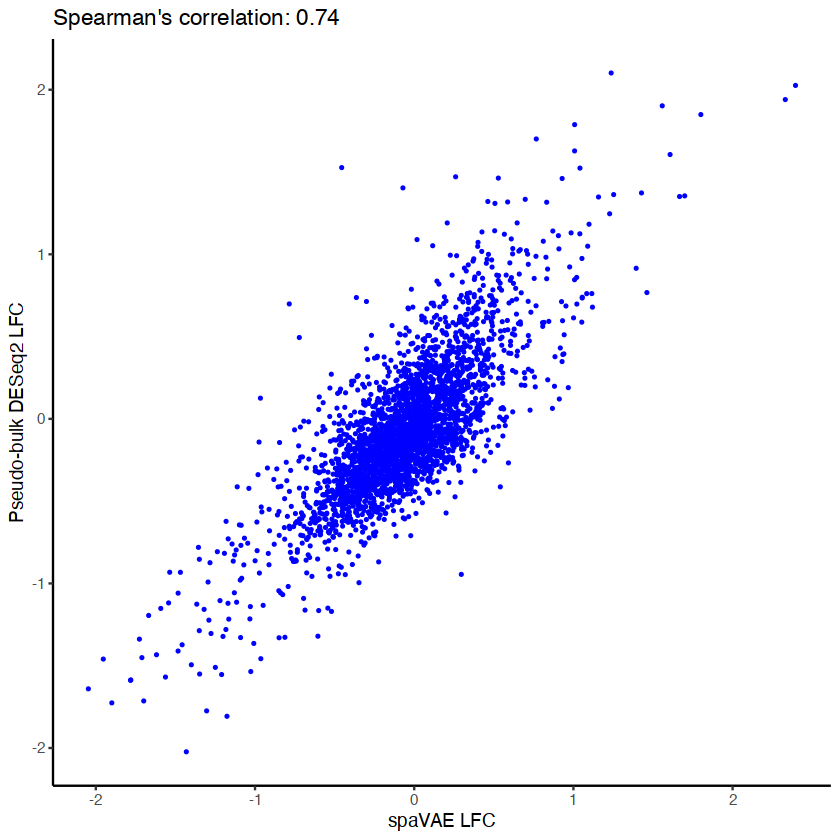

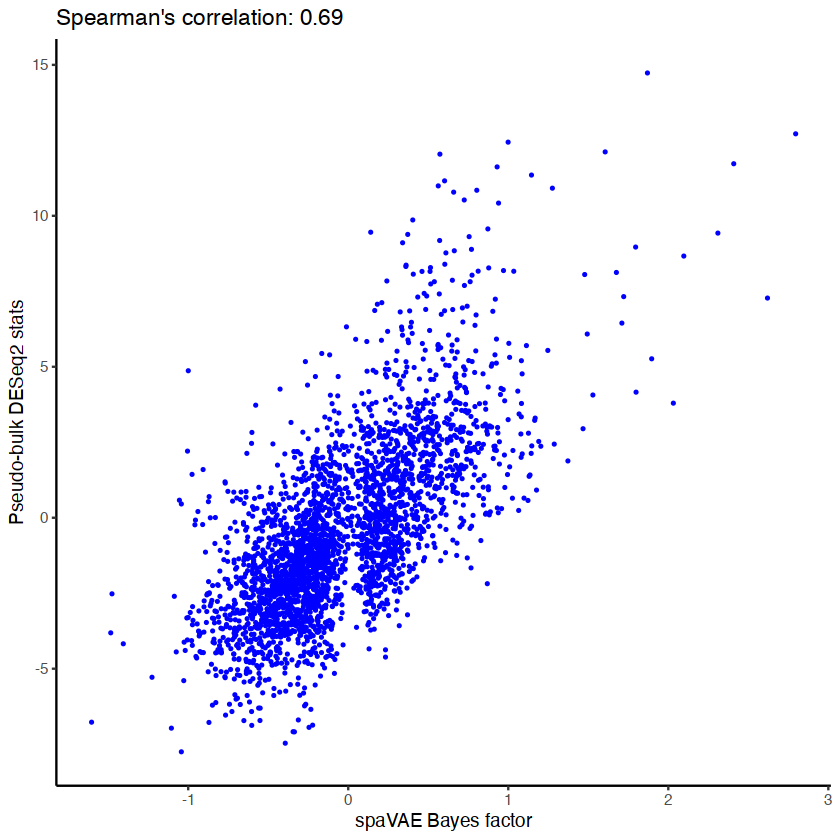

In [4]:
layer1_bulk_DE <- read.csv("Layer1_vs_others.csv", row.names = 1) # load pseudo-bulk DE result of layer1 vs others
layer1_LFC <- read.table("Layer1_vs_others_LFC.txt", sep=",", row.names = 1, header=T) # load spaVAE LFC of layer1 vs others
intersect.genes <- intersect(rownames(layer1_LFC), rownames(layer1_bulk_DE))

## plot correlation between spaVAE's LFC and bulk LFC
LFC_dat <- data.frame(spaVAE=layer1_LFC[intersect.genes, "LFC"],
                    bulk=layer1_bulk_DE[intersect.genes, "log2FoldChange"])
LFC_cor <- cor(LFC_dat$spaVAE, LFC_dat$bulk, method="spearman")
ggplot(LFC_dat, aes(x=spaVAE, y=bulk)) + geom_point(color="blue", size=0.4) + 
    xlab("spaVAE LFC") + ylab("Pseudo-bulk DESeq2 LFC") + ggtitle(paste("Spearman's correlation:", round(LFC_cor, 2))) +
    theme_classic()


## plot correlation between spaVAE's Bayes factor and bulk p-value
p_dat <- data.frame(spaVAE=-log10(layer1_LFC[intersect.genes, "prob_not_DE"]) * sign(layer1_LFC[intersect.genes, "LFC"]),
                    bulk=layer1_bulk_DE[intersect.genes, "stat"])
p_cor <- cor(p_dat$spaVAE, p_dat$bulk, method="spearman")
ggplot(p_dat, aes(x=spaVAE, y=bulk)) + geom_point(color="blue", size=0.4) + 
    xlab("spaVAE Bayes factor") + ylab("Pseudo-bulk DESeq2 stats") + ggtitle(paste("Spearman's correlation:", round(p_cor, 2))) +
    theme_classic()